## Filing Lag
### What is the delay between Calcbench processing the earnings press release and the XBRL 10-K/Q?
### In general companies publish an earnings-press-release, either on a news wire or as an 8-K.  The earnings press release has the face financials and some KPIs.  Calcbench does our best to extract the numbers from the earnings press release.
### A few minutes to ~10 days later the company files and XBRL encoded 10-K/Q with face financials and footnotes.  Calcbench extracts the numbers from the XBRL.

In [2]:
import calcbench as cb
from calcbench.filing import FilingType
from datetime import date
import numpy as np

In [3]:
filings = cb.filings_dataframe(
    start_date=date(2022, 10, 12), end_date=date(2022, 11, 12)
)

In [5]:
def filing_timeline(filings):
    filings = filings.sort_values('calcbench_finished_load')
    ten_QK = filings[filings.filing_type == FilingType.annualQuarterlyReport]
    ten_KQ_filing_date = pd.NaT
    if ten_QK.shape[0] > 0:
        ten_KQ_filing_date = ten_QK.iloc[0].calcbench_finished_load
    earnings_press_release = filings[
        filings.filing_type == FilingType.eightk_earningsPressRelease
    ]
    earnings_press_release_filing_date = pd.NaT
    if earnings_press_release.shape[0] > 0:
        earnings_press_release_filing_date = earnings_press_release.iloc[
            0
        ].calcbench_finished_load

    return pd.Series(
        (
            earnings_press_release_filing_date,
            ten_KQ_filing_date,
            ten_KQ_filing_date - earnings_press_release_filing_date,
        ),
        [
            "earnings_press_release_filing_date",
            "10-KQ_filing_date",
            "press_release_to_10_KQ_lag",
        ],
    )

In [6]:
filing_lags = (
    filings.groupby(["ticker", "fiscal_year", "fiscal_period"])
    .apply(filing_timeline)
    .dropna()
)

C:\Users\andre\AppData\Local\Temp\ipykernel_22048\3311001337.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filings.groupby(["ticker", "fiscal_year", "fiscal_period"])
C:\Users\andre\AppData\Local\Temp\ipykernel_22048\3311001337.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(filing_timeline)


In [7]:
filing_lags.to_excel("filing_timeline.xlsx")

### Most of the 10-K/Qs a received on the same day

<Axes: ylabel='Frequency'>

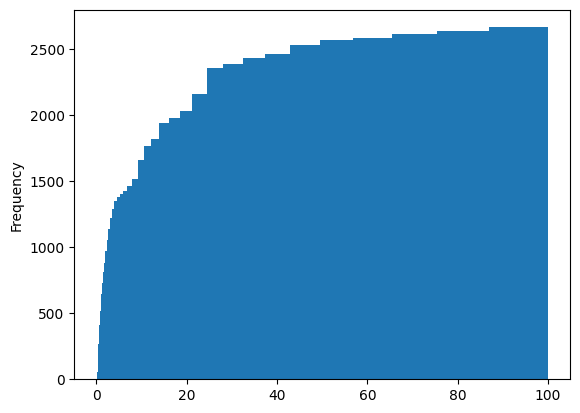

In [16]:
(filing_lags.press_release_to_10_KQ_lag / pd.Timedelta(hours=1)).plot.hist(
    cumulative=True, bins=np.logspace(-1, 2, 50)
)

In [17]:
filing_lags.press_release_to_10_KQ_lag.describe()

count                         3385
mean     2 days 12:49:01.980206794
std      4 days 18:44:06.413558367
min              -6 days +20:14:38
25%                0 days 01:32:00
50%                0 days 09:51:43
75%                1 days 15:06:05
max               27 days 07:59:15
Name: press_release_to_10_KQ_lag, dtype: object

## Filing Data
### What data are we getting from earnings press-releases vs XBRL 10-K/Qs?

In [18]:
company_idenfiers = ["PEP"]

In [19]:
data = cb.standardized(company_identifiers=company_idenfiers, point_in_time=True)

In [20]:
pep_data = data.merge(
    filings[["fiscal_year", "fiscal_period"]].rename(
        columns={
            "fiscal_year": "filing_fiscal_year",
            "fiscal_period": "filing_fiscal_period",
        }
    ),
    left_on="filing_id",
    right_index=True,
)

### For PEP Calcbench extracted 51 values from the 8-K and 94 from the 10-Q.
#### Number from both the 8-K and 10-Q are only included in the 8-K count.

In [21]:
pep_data['filing_type'].value_counts()

filing_type
10-Q    126
8-K      74
Name: count, dtype: Int64